In [1]:
import torch
from torchvision import datasets, models, transforms

In [2]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [3]:
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
data_dir = '/Users/topih/Pytorch/datasets/fruits'

In [5]:
image_datasets = {}

In [6]:
image_datasets['train']=datasets.ImageFolder(data_dir + '/Train', train_transform)

In [7]:
image_datasets['test']=datasets.ImageFolder(data_dir + '/Test', train_transform)

In [8]:
print("Training data size - %d" % len(image_datasets['train']))
print("Test data size - %d" % len(image_datasets['test']))

Training data size - 4787
Test data size - 1612


In [9]:
class_names = image_datasets['train'].classes

In [10]:
class_names

['Apple',
 'Avocado',
 'Banana',
 'Mango',
 'Orange',
 'Pear',
 'Pineapple',
 'Plum',
 'Raspberry',
 'Strawberry']

In [11]:
len(class_names)

10

In [12]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 4787
     Root Location: /Users/topih/Pytorch/datasets/fruits/Train
     Transforms (if any): Compose(
                              Resize(size=256, interpolation=PIL.Image.BILINEAR)
                              RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                              RandomHorizontalFlip(p=0.5)
                              ToTensor()
                              Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                          )
     Target Transforms (if any): None, 'test': Dataset ImageFolder
     Number of datapoints: 1612
     Root Location: /Users/topih/Pytorch/datasets/fruits/Test
     Transforms (if any): Compose(
                              Resize(size=256, interpolation=PIL.Image.BILINEAR)
                              RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=

In [13]:
dataloaders = {}

In [14]:
dataloaders['train'] = torch.utils.data.DataLoader(image_datasets['train'],
                                                  batch_size=8,
                                                  shuffle=True,
                                                  num_workers=4)

In [15]:
dataloaders['test'] = torch.utils.data.DataLoader(image_datasets['test'],
                                                  batch_size=8,
                                                  shuffle=True,
                                                  num_workers=4)

In [16]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x210348ed630>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x210348ed940>}

In [17]:
inputs, labels = next(iter(dataloaders['train']))

In [18]:
inputs.shape

torch.Size([8, 3, 224, 224])

In [19]:
labels

tensor([2, 2, 9, 0, 2, 3, 1, 6])

In [20]:
import torchvision
inp = torchvision.utils.make_grid(inputs)

In [21]:
inp.shape

torch.Size([3, 228, 1810])

In [22]:
inp.max()

tensor(2.6400)

In [23]:
import numpy as np
np.clip(inp, 0, 1).max()

tensor(1.)

In [24]:
inp.numpy().transpose((1, 2, 0)).shape

(228, 1810, 3)

In [25]:
import matplotlib.pyplot as plt
plt.ion()

In [26]:
def img_show(inp, title=None):
    inp = inp.numpy().transpose((1,2,0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize=(10,4))
    plt.axis('off')
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)

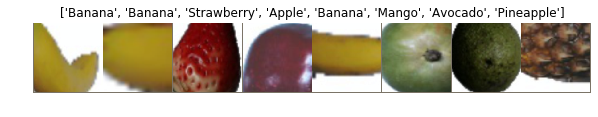

In [27]:
img_show(inp, title=[class_names[x] for x in labels])

In [28]:
model = models.resnet18(pretrained=True)

In [29]:
num_ftrs = model.fc.in_features
num_ftrs

512

In [30]:
import torch.nn as nn

In [31]:
model.fc = nn.Linear(num_ftrs, len(class_names))

In [32]:
criterion = nn.CrossEntropyLoss()

In [33]:
import torch.optim as optim

In [34]:
optimizer = optim.SGD(model.parameters(),
                     lr=0.001,
                     momentum=0.9)

In [35]:
from torch.optim import lr_scheduler

In [36]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer,
                                      step_size=7,
                                      gamma=0.1)

In [37]:
def calculate_accuracy(phase, running_loss, running_corrects):
    epoch_loss = running_loss / len(image_datasets[phase])
    epoch_acc = running_corrects.double() / len(image_datasets[phase])
    
    print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    
    return(epoch_loss, epoch_acc)

In [38]:
def phase_train(model, criterion, optimizer, scheduler):
    scheduler.step()
    model.train()
    running_loss = 0.0
    running_corrects = 0
    nemuro=0
    
    for inputs, labels in dataloaders['train']:
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            print('train phase loop: ', nemuro)
            nemuro = nemuro + 1
            
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    calculate_accuracy('train', running_loss, running_corrects)
        

In [39]:
import copy

In [40]:
best_acc = 0.0

In [41]:
def phase_test(model, criterion, optimizer):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    global best_acc
    numero = 0
    for inputs, labels in dataloaders['test']:
        optimizer.zero_grad()
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        print('test phase loop: ', numero)
        numero = numero + 1
        
    epoch_loss, epoch_acc = calculate_accuracy('test', running_loss, running_corrects)
    
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        
    return best_model_wts
        

In [42]:
def build_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        phase_train(model, criterion, optimizer, scheduler)
        best_model_wts = phase_test(model, criterion, optimizer)
        print()
        
        
    print('Best test Acc: {:4f}'.format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [43]:
model = build_model(model,
                   criterion,
                   optimizer,
                   exp_lr_scheduler,
                   num_epochs=1)

Epoch 0/0
----------
train phase loop:  0
train phase loop:  1
train phase loop:  2
train phase loop:  3
train phase loop:  4
train phase loop:  5
train phase loop:  6
train phase loop:  7
train phase loop:  8
train phase loop:  9
train phase loop:  10
train phase loop:  11
train phase loop:  12
train phase loop:  13
train phase loop:  14
train phase loop:  15
train phase loop:  16
train phase loop:  17
train phase loop:  18
train phase loop:  19
train phase loop:  20
train phase loop:  21
train phase loop:  22
train phase loop:  23
train phase loop:  24
train phase loop:  25
train phase loop:  26
train phase loop:  27
train phase loop:  28
train phase loop:  29
train phase loop:  30
train phase loop:  31
train phase loop:  32
train phase loop:  33
train phase loop:  34
train phase loop:  35
train phase loop:  36
train phase loop:  37
train phase loop:  38
train phase loop:  39
train phase loop:  40
train phase loop:  41
train phase loop:  42
train phase loop:  43
train phase loop:  44

train phase loop:  360
train phase loop:  361
train phase loop:  362
train phase loop:  363
train phase loop:  364
train phase loop:  365
train phase loop:  366
train phase loop:  367
train phase loop:  368
train phase loop:  369
train phase loop:  370
train phase loop:  371
train phase loop:  372
train phase loop:  373
train phase loop:  374
train phase loop:  375
train phase loop:  376
train phase loop:  377
train phase loop:  378
train phase loop:  379
train phase loop:  380
train phase loop:  381
train phase loop:  382
train phase loop:  383
train phase loop:  384
train phase loop:  385
train phase loop:  386
train phase loop:  387
train phase loop:  388
train phase loop:  389
train phase loop:  390
train phase loop:  391
train phase loop:  392
train phase loop:  393
train phase loop:  394
train phase loop:  395
train phase loop:  396
train phase loop:  397
train phase loop:  398
train phase loop:  399
train phase loop:  400
train phase loop:  401
train phase loop:  402
train phase

test phase loop:  126
test phase loop:  127
test phase loop:  128
test phase loop:  129
test phase loop:  130
test phase loop:  131
test phase loop:  132
test phase loop:  133
test phase loop:  134
test phase loop:  135
test phase loop:  136
test phase loop:  137
test phase loop:  138
test phase loop:  139
test phase loop:  140
test phase loop:  141
test phase loop:  142
test phase loop:  143
test phase loop:  144
test phase loop:  145
test phase loop:  146
test phase loop:  147
test phase loop:  148
test phase loop:  149
test phase loop:  150
test phase loop:  151
test phase loop:  152
test phase loop:  153
test phase loop:  154
test phase loop:  155
test phase loop:  156
test phase loop:  157
test phase loop:  158
test phase loop:  159
test phase loop:  160
test phase loop:  161
test phase loop:  162
test phase loop:  163
test phase loop:  164
test phase loop:  165
test phase loop:  166
test phase loop:  167
test phase loop:  168
test phase loop:  169
test phase loop:  170
test phase

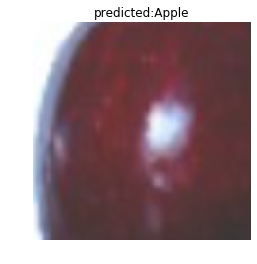

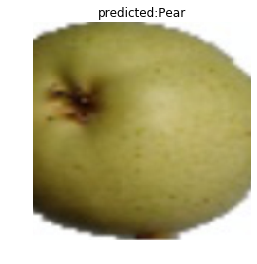

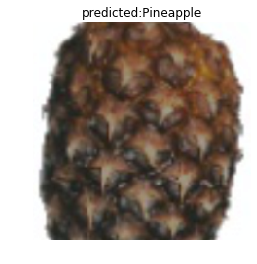

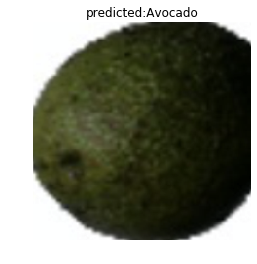

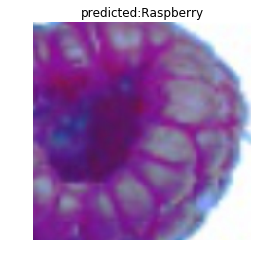

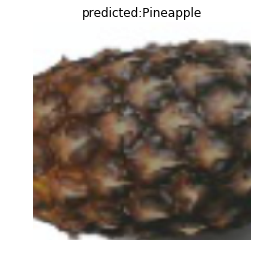

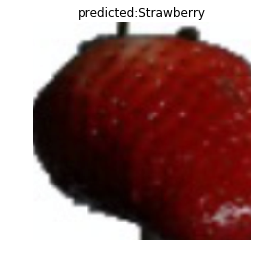

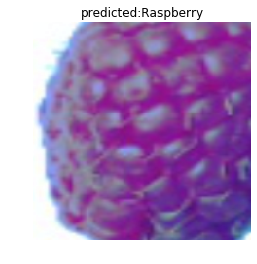

In [44]:
with torch.no_grad():
    inputs, labels = iter(dataloaders['test']).next()
    inp = torchvision.utils.make_grid(inputs)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    
    for j in range(len(inputs)):
        inp = inputs.data[j]
        img_show(inp, 'predicted:' + class_names[preds[j]])

In [46]:
frozen_model = models.resnet18(pretrained=True)

In [47]:
for param in frozen_model.parameters():
    param.requires_grad = False

In [48]:
frozen_model.fc = nn.Linear(num_ftrs, len(class_names))

In [49]:
optimizer = optim.SGD(frozen_model.fc.parameters(),
                     lr=0.001,
                     momentum=0.9)

In [51]:
exp_lr_scheduler = lr_scheduler.StepLR(optimizer,
                                      step_size=7,
                                      gamma=0.1)

In [52]:
criterion = nn.CrossEntropyLoss()

In [53]:
best_acc = 0.0

In [55]:
frozen_model = build_model(frozen_model,
                          criterion,
                          optimizer,
                          exp_lr_scheduler,
                          num_epochs=1)

Epoch 0/0
----------
train phase loop:  0
train phase loop:  1
train phase loop:  2
train phase loop:  3
train phase loop:  4
train phase loop:  5
train phase loop:  6
train phase loop:  7
train phase loop:  8
train phase loop:  9
train phase loop:  10
train phase loop:  11
train phase loop:  12
train phase loop:  13
train phase loop:  14
train phase loop:  15
train phase loop:  16
train phase loop:  17
train phase loop:  18
train phase loop:  19
train phase loop:  20
train phase loop:  21
train phase loop:  22
train phase loop:  23
train phase loop:  24
train phase loop:  25
train phase loop:  26
train phase loop:  27
train phase loop:  28
train phase loop:  29
train phase loop:  30
train phase loop:  31
train phase loop:  32
train phase loop:  33
train phase loop:  34
train phase loop:  35
train phase loop:  36
train phase loop:  37
train phase loop:  38
train phase loop:  39
train phase loop:  40
train phase loop:  41
train phase loop:  42
train phase loop:  43
train phase loop:  44

train phase loop:  360
train phase loop:  361
train phase loop:  362
train phase loop:  363
train phase loop:  364
train phase loop:  365
train phase loop:  366
train phase loop:  367
train phase loop:  368
train phase loop:  369
train phase loop:  370
train phase loop:  371
train phase loop:  372
train phase loop:  373
train phase loop:  374
train phase loop:  375
train phase loop:  376
train phase loop:  377
train phase loop:  378
train phase loop:  379
train phase loop:  380
train phase loop:  381
train phase loop:  382
train phase loop:  383
train phase loop:  384
train phase loop:  385
train phase loop:  386
train phase loop:  387
train phase loop:  388
train phase loop:  389
train phase loop:  390
train phase loop:  391
train phase loop:  392
train phase loop:  393
train phase loop:  394
train phase loop:  395
train phase loop:  396
train phase loop:  397
train phase loop:  398
train phase loop:  399
train phase loop:  400
train phase loop:  401
train phase loop:  402
train phase

test phase loop:  126
test phase loop:  127
test phase loop:  128
test phase loop:  129
test phase loop:  130
test phase loop:  131
test phase loop:  132
test phase loop:  133
test phase loop:  134
test phase loop:  135
test phase loop:  136
test phase loop:  137
test phase loop:  138
test phase loop:  139
test phase loop:  140
test phase loop:  141
test phase loop:  142
test phase loop:  143
test phase loop:  144
test phase loop:  145
test phase loop:  146
test phase loop:  147
test phase loop:  148
test phase loop:  149
test phase loop:  150
test phase loop:  151
test phase loop:  152
test phase loop:  153
test phase loop:  154
test phase loop:  155
test phase loop:  156
test phase loop:  157
test phase loop:  158
test phase loop:  159
test phase loop:  160
test phase loop:  161
test phase loop:  162
test phase loop:  163
test phase loop:  164
test phase loop:  165
test phase loop:  166
test phase loop:  167
test phase loop:  168
test phase loop:  169
test phase loop:  170
test phase

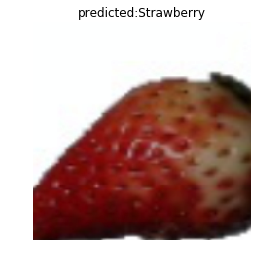

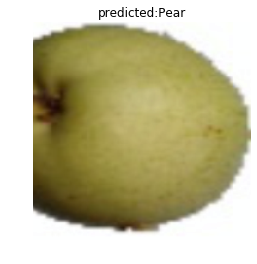

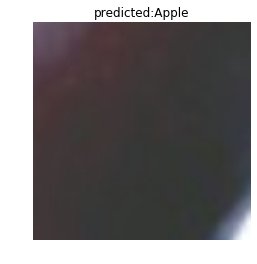

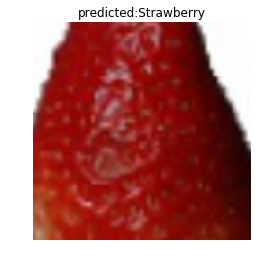

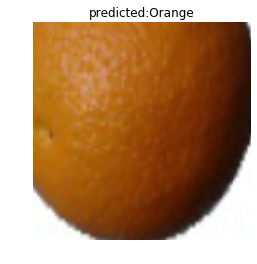

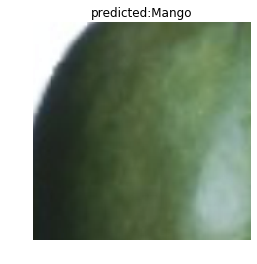

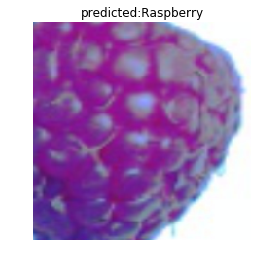

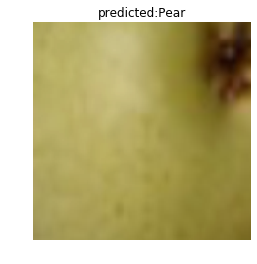

In [56]:
with torch.no_grad():
    inputs, labels = iter(dataloaders['test']).next()
    inp = torchvision.utils.make_grid(inputs)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    
    for j in range(len(inputs)):
        inp = inputs.data[j]
        img_show(inp, 'predicted:' + class_names[preds[j]])